### Explore boundary conditions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates
import sys  
sys.path.insert(0, '/home/users/birgal/')
from nemo_python import plots
import cartopy.crs as ccrs
import matplotlib.path as mpath
import glob
import cmocean
import pickle

#### Functions

In [2]:
def Hovmueller_slice(ax, dataset, variable, depth_slice=10):#, vmin=0, vmax=1):
    # Plot slice along boundary of variable

    try:
        c = ax.pcolormesh(dataset.indexes['time_counter'].to_datetimeindex(), dataset['nav_lon'][0,:], dataset[variable][:,0,:].transpose());
    except: # variable has depth as well, default to depth_slice=10
        c = ax.pcolormesh(dataset.indexes['time_counter'].to_datetimeindex(), dataset['nav_lon'][0,:], dataset[variable][:,depth_slice,0,:].transpose());
    ax.set_xlabel('time (5-day)')
    # ax.set_ylabel('coordinate')
    ax.set_title(dataset[variable].long_name)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    fig.colorbar(c, ax=ax)

    return

In [3]:
def prepare_plot(figsize=(15, 15)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -51], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
    gl = ax.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [4]:
def bdy_transect(ax, dataset, variable, depth, time_slice=10):

    ax.set_xlabel(f'longitude (\N{DEGREE SIGN}E)')
    ax.set_ylabel('depth (m)')
    ax.invert_yaxis()
    ax.set_xlim(-180,180)

    xx, yy = np.meshgrid(dataset['nav_lon'][0,:], dataset[depth])

    c = ax.pcolormesh(xx, yy, dataset[variable][time_slice,:,0,:])
    ax.plot(mesh1['nav_lon'][-1,:], mesh1['bathy_metry'][0,-1,:], '-w')

    fig.colorbar(c, ax=ax, label=dataset[variable].long_name)
    return

#### Load files

In [ ]:
# Boundary forcing files
bdy_ice = xr.Dataset(); bdy_tra = xr.Dataset(); bdy_U = xr.Dataset(); bdy_V = xr.Dataset();
for year in [1979, 1980, 1981]:
    bdy_ice_add = xr.open_dataset(f'/home/users/birgal/data/forcing_NEMO/bdyT_ice_y{year}.nc')
    bdy_tra_add = xr.open_dataset(f'/home/users/birgal/data/forcing_NEMO/bdyT_tra_y{year}.nc')
    bdy_U_add   = xr.open_dataset(f'/home/users/birgal/data/forcing_NEMO/bdyU_u3d_y{year}.nc')
    bdy_V_add   = xr.open_dataset(f'/home/users/birgal/data/forcing_NEMO/bdyV_u3d_y{year}.nc')
    
    bdy_ice = bdy_ice.merge(bdy_ice_add)
    bdy_tra = bdy_tra.merge(bdy_tra_add)
    bdy_U   = bdy_U.merge(bdy_U_add)
    bdy_V   = bdy_V.merge(bdy_V_add)

In [6]:
# Model grid for mask
mesh1 = xr.open_dataset('/home/users/birgal/data/NEMO-test3-20230914/domain_cfg.nc')
mesh_bdy = xr.open_dataset('/home/users/birgal/data/NEMO-test3-20230914/coordinates_bdy.nc')

In [7]:
bdy_tra

<xarray.Dataset>
Dimensions:            (time_counter: 219, bnds: 2, yb: 1, xbT: 1424,
                        deptht: 121)
Coordinates:
  * time_counter       (time_counter) object 1979-01-03 12:00:00 ... 1981-12-...
    nav_lon            (yb, xbT) float64 73.0 73.25 73.5 ... 72.25 72.5 72.75
    nav_lat            (yb, xbT) float64 -52.41 -52.41 -52.41 ... -52.41 -52.41
  * deptht             (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
Dimensions without coordinates: bnds, yb, xbT
Data variables:
    time_counter_bnds  (time_counter, bnds) object 1979-01-01 00:00:00 ... 19...
    deptht_bnds        (deptht, bnds) float32 0.0 1.0 1.0 ... 5.8e+03 6.004e+03
    nbidta             (yb, xbT) int32 1 2 3 4 5 6 ... 1436 1437 1438 1439 1440
    nbjdta             (yb, xbT) int32 438 438 438 438 438 ... 438 438 438 438
    nbrdta             (yb, xbT) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    sossh              (time_counter, yb, xbT) float32 -0.8551 -0.8514 ... -1.04
    vosaline           (time_counter, deptht, yb, xbT) float32 34.07 ... 0.0
    votemper           (time_counter, deptht, yb, xbT) float32 2.929 ... 0.0

### Explore

In [5]:
# Load polygon from disc
with open('/home/users/birgal/data/IBCSO_isobath_1000m_polygon', "rb") as poly_file:
    isobath_1000m_polygon = pickle.load(poly_file)

In [6]:
# Definitions used for plotting

# To make circular maps:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

# Isobath 2000 m polygon
x_iso, y_iso = isobath_1000m_polygon.exterior.xy
x_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(x_iso)) # need to separate longitudes because otherwise matplotlib plotting artifact
y_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(y_iso))
x_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(x_iso))
y_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(y_iso))

/tmp/ipykernel_4278/3050931017.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  c = ax.pcolormesh(dataset.indexes['time_counter'].to_datetimeindex(), dataset['nav_lon'][0,:], dataset[variable][:,0,:].transpose());
/tmp/ipykernel_4278/3050931017.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(dataset.indexes['time_counter'].to_datetimeindex(), dataset['nav_lon'][0,:], dataset[variable][:,0,:].transpose());
/tmp/ipykernel_4278/3050931017.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.Date

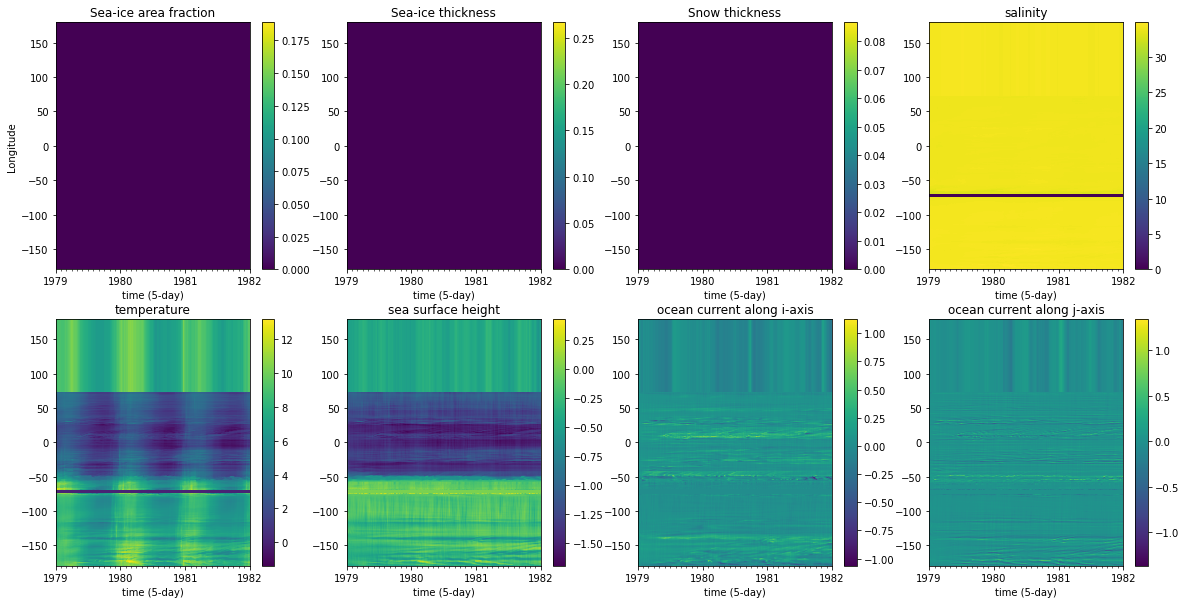

In [164]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
vars_ice = ['siconc', 'sithic', 'snthic']
vars_tra = ['vosaline', 'votemper', 'sossh']
vars_U   = ['vozocrtx']
vars_V   = ['vomecrty']
ax[0,0].set_ylabel('Longitude')

for a, var in enumerate(vars_ice):
    Hovmueller_slice(ax.ravel()[a], bdy_ice, var)

for var in vars_tra:
    a+=1
    Hovmueller_slice(ax.ravel()[a], bdy_tra, var, depth_slice=0)

for var in vars_U:
    a+=1
    Hovmueller_slice(ax.ravel()[a], bdy_U, var)

for var in vars_V:
    a+=1
    Hovmueller_slice(ax.ravel()[a], bdy_V, var)

Look at values on the map

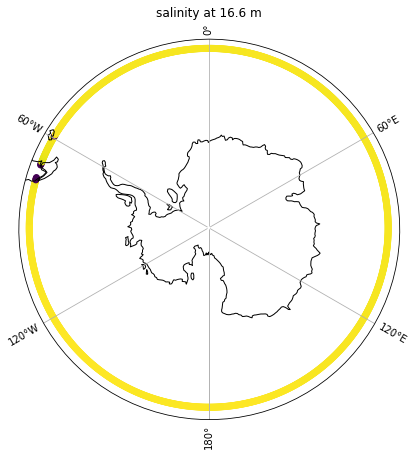

In [143]:
fig, ax = prepare_plot()
ax.scatter(bdy_tra['nav_lon'][0,:], bdy_tra['nav_lat'][0,:], c=bdy_tra['vosaline'][0,10,0,:], transform=ccrs.PlateCarree());
ax.set_title(bdy_tra['vosaline'].long_name + f' at {deptht.values[10]:.1f} m');

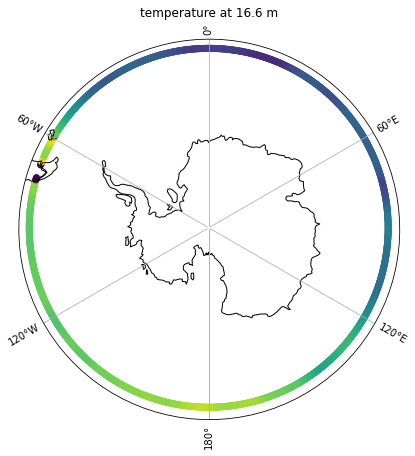

In [142]:
fig, ax = prepare_plot()
ax.scatter(bdy_tra['nav_lon'][0,:], bdy_tra['nav_lat'][0,:], c=bdy_tra['votemper'][0,10,0,:], transform=ccrs.PlateCarree());
ax.set_title(bdy_tra['votemper'].long_name + f' at {deptht.values[10]:.1f} m');

Also look at depth slices along the transect

/tmp/ipykernel_546/2183237822.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(xx, yy, dataset[variable][time_slice,:,0,:])


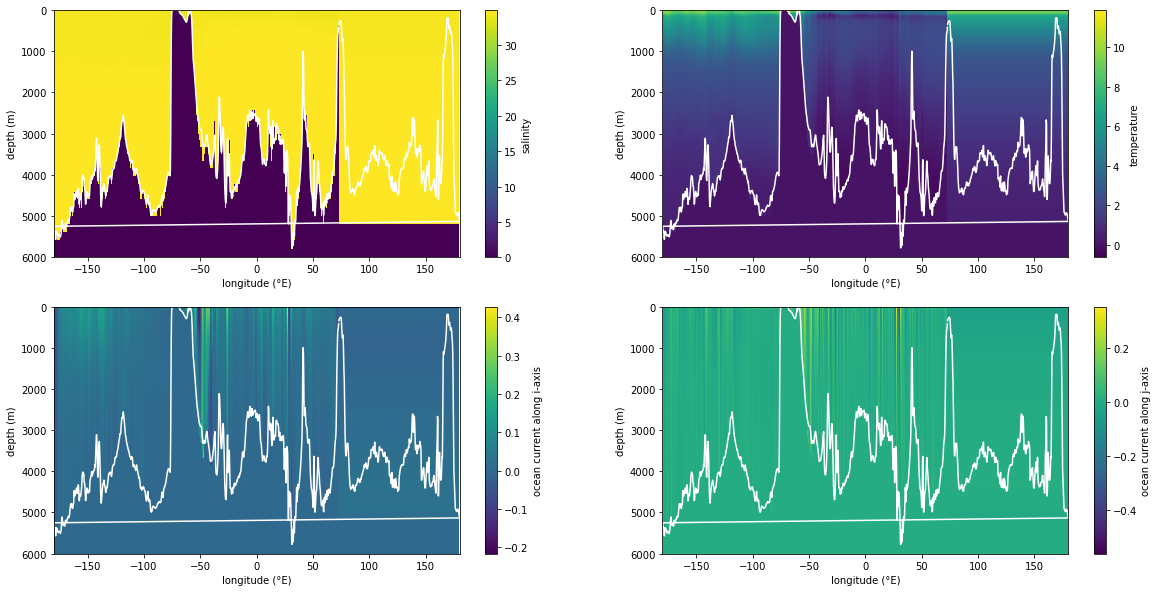

In [130]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
vars_tra = ['vosaline', 'votemper']
vars_U   = ['vozocrtx']
vars_V   = ['vomecrty']

a=0
for var in vars_tra:
    bdy_transect(ax.ravel()[a], bdy_tra, var, 'deptht', time_slice=10)
    a+=1

for var in vars_U:
    bdy_transect(ax.ravel()[a], bdy_U, var, 'depthu', time_slice=10)
    a+=1

for var in vars_V:
    bdy_transect(ax.ravel()[a], bdy_V, var, 'depthv', time_slice=10)
    a+=1

#### Look at output from run with boundary conditions held constant to initial conditions over 10 rimwidth, with coordinates specified in namelist_bdy

In [7]:
output_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/bdy-test22/'

In [12]:
gridU_files = glob.glob(f'{output_folder}eANT025.L121_1d_19790101_19791231_grid_U_197901*')[-2:]
gridV_files = glob.glob(f'{output_folder}eANT025.L121_1d_19790101_19791231_grid_V_197901*')[0:2]
gridT_files = glob.glob(f'{output_folder}eANT025.L121_1d_19790101_19791231_grid_T_197901*')[-2:]

In [13]:
# gridU_dataset = xr.open_dataset(gridU_files[0])
gridV_dataset = xr.open_dataset(gridV_files[0])
# gridT_dataset = xr.open_dataset(gridT_files[0])
for file in gridV_files[1:]:
    # gridU_dataset = gridU_dataset.merge(xr.open_dataset(file))
    gridV_dataset = gridV_dataset.merge(xr.open_dataset(file))
    # gridT_dataset = gridT_dataset.merge(xr.open_dataset(file))

In [14]:
nav_lon = xr.open_dataset(gridV_files[0])['nav_lon']
nav_lat = xr.open_dataset(gridV_files[0])['nav_lat']

gridU

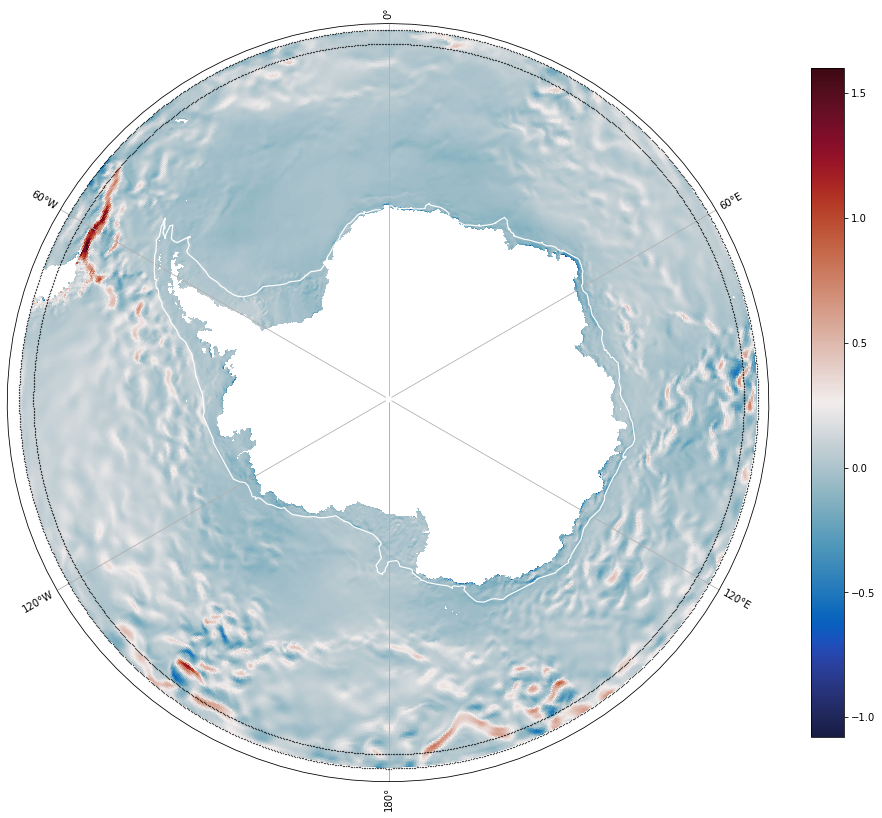

In [26]:
fig, ax = prepare_plot()

depth = 0
time  = 0

gridU_plot = np.ma.masked_where(gridU_dataset['uo'][time,depth,:,:] == 0, gridU_dataset['uo'][time,depth,:,:])

cm = ax.pcolormesh(nav_lon, nav_lat, gridU_plot, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance);
ax.scatter(nav_lon[-10, :], nav_lat[-10, :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)
ax.scatter(nav_lon[-1 , :], nav_lat[-1 , :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)

# add 1000 m isobath contour to each of the plots 
ax.plot(x_iso1, y_iso1, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm, ax=ax, fraction=0.04)

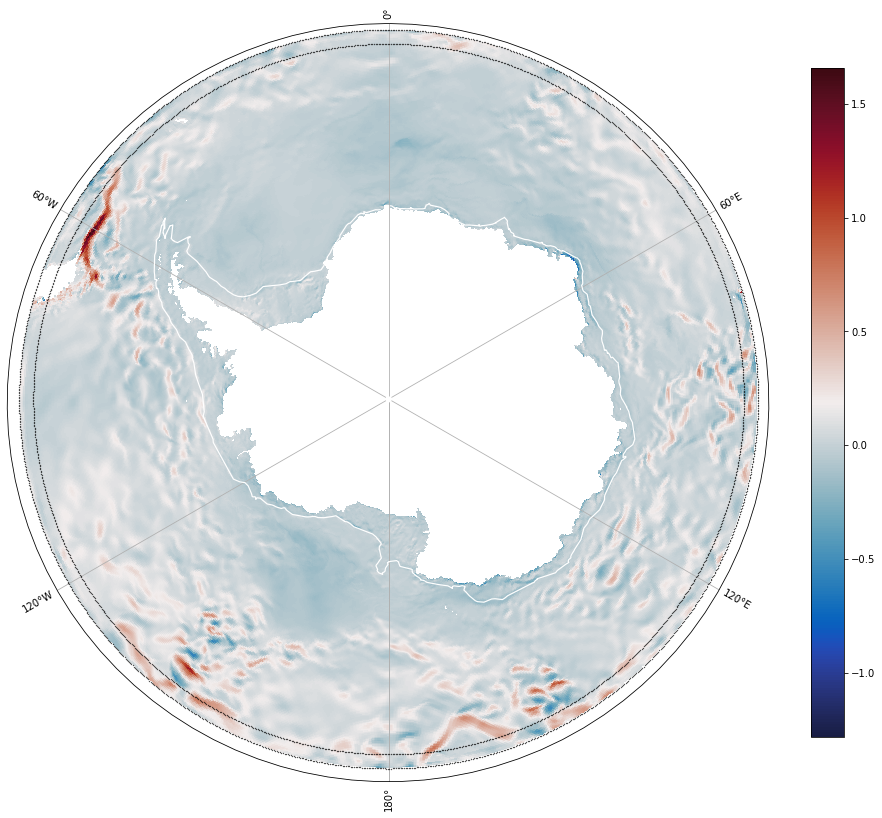

In [32]:
fig, ax = prepare_plot()

depth = 0
time  = 1

gridU_plot = np.ma.masked_where(gridU_dataset['uo'][time,depth,:,:] == 0, gridU_dataset['uo'][time,depth,:,:])

cm = ax.pcolormesh(nav_lon, nav_lat, gridU_plot, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance);
ax.scatter(nav_lon[-10, :], nav_lat[-10, :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)
ax.scatter(nav_lon[-1 , :], nav_lat[-1 , :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)

# add 1000 m isobath contour to each of the plots 
ax.plot(x_iso1, y_iso1, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm, ax=ax, fraction=0.04)

# ax.set_title(bdy_tra['vosaline'].long_name + f' at {deptht.values[0]:.1f} m');

gridV

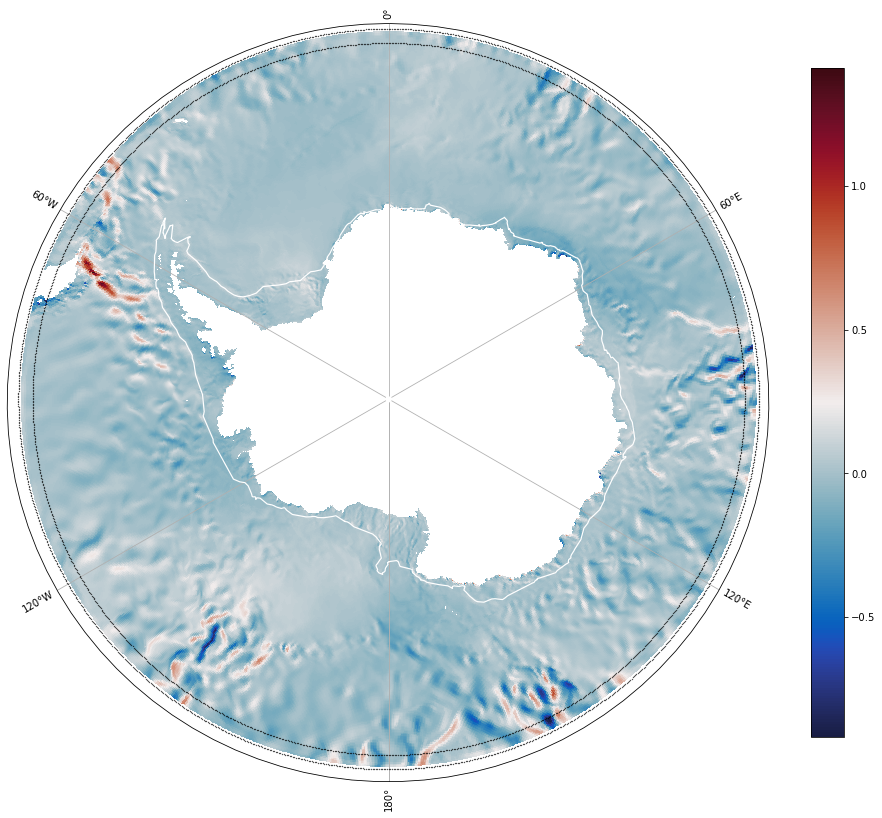

In [15]:
fig, ax = prepare_plot()

depth = 0
time  = 0

gridV_plot = np.ma.masked_where(gridV_dataset['vo'][time,depth,:,:] == 0, gridV_dataset['vo'][time,depth,:,:])

cm = ax.pcolormesh(nav_lon, nav_lat, gridV_plot, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance);
ax.scatter(nav_lon[-10, :], nav_lat[-10, :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)
ax.scatter(nav_lon[-1 , :], nav_lat[-1 , :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)

# add 1000 m isobath contour to each of the plots 
ax.plot(x_iso1, y_iso1, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm, ax=ax, fraction=0.04)

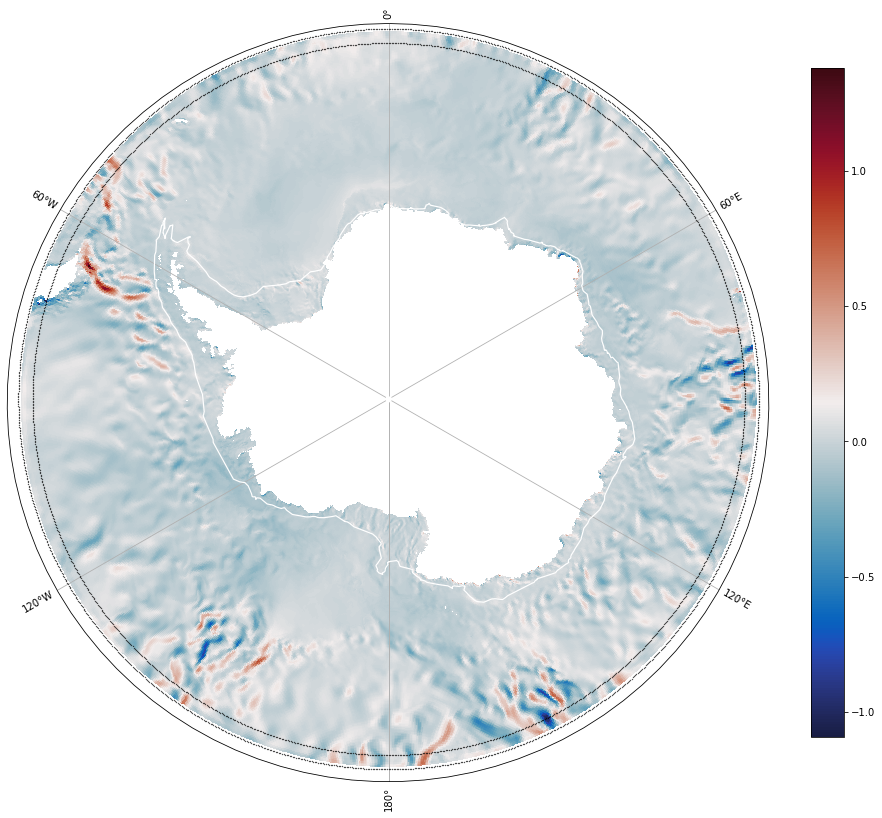

In [11]:
fig, ax = prepare_plot()

depth = 0
time  = 1

gridV_plot = np.ma.masked_where(gridV_dataset['vo'][time,depth,:,:] == 0, gridV_dataset['vo'][time,depth,:,:])

cm = ax.pcolormesh(nav_lon, nav_lat, gridV_plot, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance);
ax.scatter(nav_lon[-10, :], nav_lat[-10, :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)
ax.scatter(nav_lon[-1 , :], nav_lat[-1 , :], c='k', zorder=3, transform=ccrs.PlateCarree(), s=0.1)

# add 1000 m isobath contour to each of the plots 
ax.plot(x_iso1, y_iso1, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='w', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm, ax=ax, fraction=0.04)